In [286]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import copy

from PIL import Image, ImageOps

import cv2

import pdb

## An initial Look and basic feature engineering

Here I do a very rough first look at the data, to try and get a feel for what the images look like. When possible, I'll do some rough pre-processing on the image, but the focus of this notebook is get the data in a format in which I can work with it. 

### 0. Loading the data

First, I'll import the data, as instructed on the course website. Note that I'm loading the test images (not the training images), only because the file is smaller and I want to save time. 

In [2]:
X_test = np.loadtxt("../data/raw/test_x.csv", delimiter=",") # load from text 
y_train = np.loadtxt("../data/raw/train_y.csv", delimiter=",") 
X_test = X_test.reshape(-1, 64, 64) # reshape 
y_train = y_train.reshape(-1, 1) 

In [6]:
# What's the dimension of this loaded matrix? 
X_test.shape

(10000, 64, 64)

In [8]:
X_test[0].shape

(64, 64)

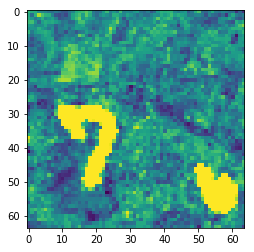

In [7]:
plt.imshow(X_test[0])

Looks a bit weird. I don't think Matplotlib knows that this is a greyscale image. 

Better to user Pillow:

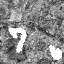

In [8]:
Image.fromarray(X_test[0]).convert("L")

That's better. 

Looking at the first couple of images to get a feel for what they look like:

In [3]:
# a function for stiching a bunch of square images together
def gallery(array, ncols=3):
    nindex, height, width = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols)
    result = (array.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    return result

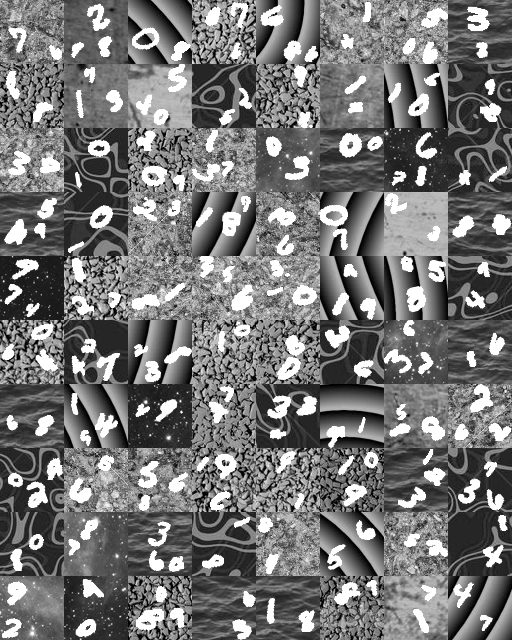

In [10]:
result = gallery(X_test[0:80], ncols = 8)
Image.fromarray(result).convert("L")

Ok. Some important things to note here:

1. The images have _really_ noisy backgrounds, which dont seem to have any correlation to the numbers. 
2. The images themselves are all pure white. This is great! It means that if we convert everything that's not white to black, we will essentially have removed the noisy backgrounds. 
3. The largest image in each picture doesn't seem to be the larges by such a large margin. This will be a hard problem for a vanilla CNN. 
    - We will likely have to isolate the largest image from each picture using a bounding box. Perhaps a sliding window approach may work...


## 1. Removing noisy backgrounds

A first, obvious step to removing the noise in the backgrounds is to convert the images from greyscale to *black **OR** white* images. This will keep only the numbers, effectivly, if all goes well. 

First, trying this out on a first image:

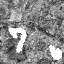

In [11]:
first = Image.fromarray(X_test[0]).convert("L")
first

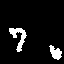

In [12]:
blackORwhite = first.point(lambda x: 0 if x<255 else 255, '1')
blackORwhite

That looks good. Here's a function for converting the original image numpy array to a black Or white numpy array

In [4]:
def to_black_or_white(original):
    """
    Input: Numpy array of dimension [numimages]X[width]X[Height]. 
    Pixel intensities are assumed to be 8 bit integers (0 - 255).
    
    Return: Numpy array of the same dimensions, 
    though all pixels that are not white (255) become black. 
    """
    # copy, so that we don't destroy original dat by reference. 
    images = copy.deepcopy(original)
    
    # are the pixels not white? 
    notwhite = images < 255
    # if its not white, convet to black
    images[notwhite] = 0
    
    return images.astype("uint8")

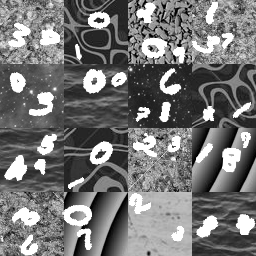

In [54]:
before = gallery(X_test[16:32], ncols = 4)
Image.fromarray(before).convert("L")

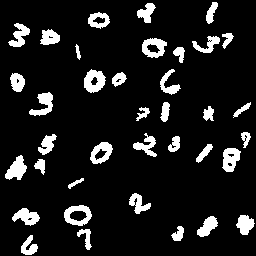

In [55]:
after = gallery(to_black_or_white(X_test[16:32]), ncols = 4)
Image.fromarray(after).convert("L")

Excellent. now to isolate the Black and white images: 

In [5]:
# a copy of the test set, but in black/white
X_test_bow = to_black_or_white(X_test)

## 2. Isolating the images - **WORK IN PROGRESS**

The goal here is to extract a rectangle image around the largest image. Largest, as defined as the image with the largest bounding image (a rotated rectangle).

Concretely, consider an example image:

In [224]:
# for example, the first image:
first = X_test_bow[0]

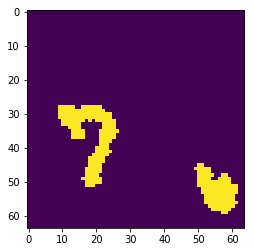

In [225]:
plt.imshow(first)

In [228]:
def getcontours(image):
    """
    Return a list of contours for an image
    """
    # find all the contours in that image
    im2, contours, hierarchy = cv2.findContours(image, 
                                      cv2.RETR_TREE,
                                      cv2.CHAIN_APPROX_SIMPLE)
    # return only the contours of greater than one pixel in size
    contours = [cnt for cnt in contours if len(cnt) > 1]
    return contours

In [229]:
# contours associated with this example image
first_contours = getcontours(first)

In [230]:
# how many contours (should be 2)
len(first_contours)

2

The function `cv2.minAreaRect()` returns bounding box around each countour. For example, the first rectangle:

In [231]:
first_rect = cv2.minAreaRect(first_contours[0])

In [232]:
# what do these rects look like? 
first_rect

((54.499996185302734, 51.50000762939453),
 (9.899494171142578, 15.55634880065918),
 -45.0)

**I'm not sure**, but what I think this `rect` is are the two opposite corner points, and the angle from the horizontal x axis of the lowest edge (Kyle, the picture I drew earlier.) Therefore, these **rect** tuples specify a _rotated_ rectangle. 

Conceptually, what we want to do is as follows:

For each image:

1. get all the contours
2. Get the bounding boxes of each of the contours (specified by the `rect` tuples, as above)
3. Calculate the area of each of these rotated rectangles, defined by the bounding boxes. **THIS IS WHAT I DON'T KNOW HOW TO DO YET**
4. For the contour that yields the largest bounding box, extract an enclosing rectangle (I'll talk about the difference between a bounding box and an enclosing rectangle in a second.)
5. Scale up the enclosing rectangle so that the larger of its two dimensions is a fixed size (say 28)
6. Paste that scaled up image onto a black square of size (28,28). This is the processed photo. 

Above, I talk about "bounding boxes" versus "enclosing rectangles". 

Bounding boxes are the smallest (potentially rotated) rectangles that can fit around an image. This is how the TA's define the "size" of each number. They are found with the `cv2.minAreaRect(cnt)` function.

Enclosing rectangles are just rectangles (not rotated) around the images. They are found with the `cv2.boundingRect(cnt)` function. 

To exemplify the difference, here are two functions I found online that extract a bounding box and an eclosing rectangle

In [233]:
def crop_minAreaRect(img, rect):

    # rotate img
    angle = rect[2]
    rows,cols = img.shape[0], img.shape[1]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    img_rot = cv2.warpAffine(img,M,(cols,rows))

    # rotate bounding box
    rect0 = (rect[0], rect[1], 0.0)
    box = cv2.boxPoints(rect)
    pts = np.int0(cv2.transform(np.array([box]), M))[0]    
    pts[pts < 0] = 0

    # crop
    img_crop = img_rot[pts[1][1]:pts[0][1], 
                       pts[1][0]:pts[2][0]]

    return img_crop

In [249]:
def crop_enclosingRect(img, cnt):
    x,y,w,h = cv2.boundingRect(cnt)
    cropped=img[y:y+h,x:x+w]
    return(cropped)

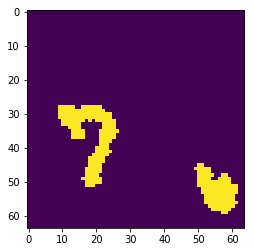

In [236]:
plt.imshow(first)

Here's the bounding box

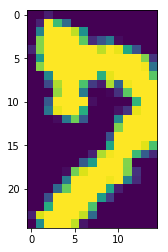

In [248]:
# get the rect associated with the `6`
rect = cv2.minAreaRect(first_contours[1])
bounding_box = crop_minAreaRect(first, rect)
# show the cropped bounding box
plt.imshow(bounding_box)

And the enclosing rectangle

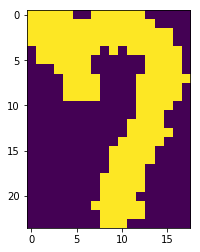

In [252]:
enclosing_rect = crop_enclosingRect(first, first_contours[1])
plt.imshow(enclosing_rect)

See how the first area is smaller than the second? It's because when the rectangle was fit on the original picture, it was fit with a small rotation, which allowed a tighter fit.

---

Fast forward. Say we're satisfied with our ability to pick the "largest" rectangle. 

We would want all the images to be the images to be the same shape (28,28), say. A naive way would be to stretch the images, but then you'd lose proportionality. 

Instead, We want to scale up the image so that it's largest dimension is 28, and then put it the middle of a black square. Here's a function for doing that:

In [256]:
def paste_onto_black(cropped, desiredsize = 28):
    
    # get the ratio with which we'll scale the size
    ratio = desiredsize/float(max(img_croped.shape))
    # the scaled size
    newsize = tuple([int(ratio*s) for s in img_croped.shape])
    # resize the image, while keeping dimensions
    im = Image.fromarray(cropped).resize(newsize)
    # Make a blank black canvas
    black = Image.new("L", size = (desiredsize,desiredsize))
    # put the image onto this black image
    black.paste(im,((desiredsize - newsize[0])//2,
               (desiredsize - newsize[1])//2))
    # return as a matrix
    return np.array(black)
    

For example: taking the rectangular image `enclosing_rect`

(24, 18)


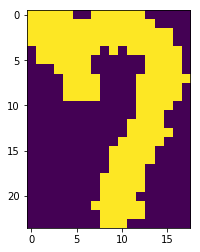

In [259]:
print(enclosing_rect.shape)
plt.imshow(enclosing_rect)

(28, 28)


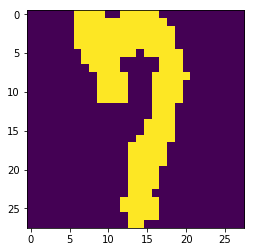

In [261]:
scaled = paste_onto_black(enclosing_rect)
print(scaled.shape)
plt.imshow(scaled)

Does a half decent job. 

---

## Experimental zone: tread with caution.

In [265]:
cv2.boundingRect(cnt)

(9, 3, 19, 20)

In [266]:
"""
From a list countours, return the largest enclosing rectangle. 
"""
def largest_enclosingRect(img, contours):
    # keep track of largest contour/area seen so far
    largest_cnt, max_area = None, -1
    
    for cnt in contours:
        # top left corner, and width/height of the image
        x,y,w,h = cv2.boundingRect(cnt)
        area = w*h
        # is this the largest image we've seen so far? 
        if area > max_area:
            max_area = area
            largest_cnt = cnt
    
    # Get the enclosing rectangle of the largest contour
    x,y,w,h = cv2.boundingRect(largest_cnt)
    # crop the image, and return
    cropped=img[y:y+h,x:x+w]
    return(cropped) 

In [281]:
def crop_images(images, desiredsize = 28):
    """
    Given an array of 64x64 black/white images, 
    return an array of the same length, where the contour with the largest _enclosing rectangle_ 
    is extracted from each image. 
    
    Each number is scaled to size (desiredsize,desiredsize).
    """
    # accumulate a modified dataset
    modified = np.ndarray((0, desiredsize, desiredsize), dtype = "uint8")
    
    for im in images:
        # find all the contours in that image
        contours = getcontours(im)
        # get the largest enclosing rectangle
        enclosing_rect = largest_enclosingRect(im, contours)
        # paste it onto a black canvas
        scaled = paste_onto_black(enclosing_rect)
        # put it in our accumulated (modified) dataset. 
        modified = np.append(modified, np.array(scaled))
        
    # when appending, images are unrolled. Roll them back up. 
    modified = modified.reshape((images.shape[0],desiredsize,desiredsize))
    
    return(modified)
    

In [282]:
cleaned = crop_images(X_test_bow)

Lets see what this does on the first 64 images. 

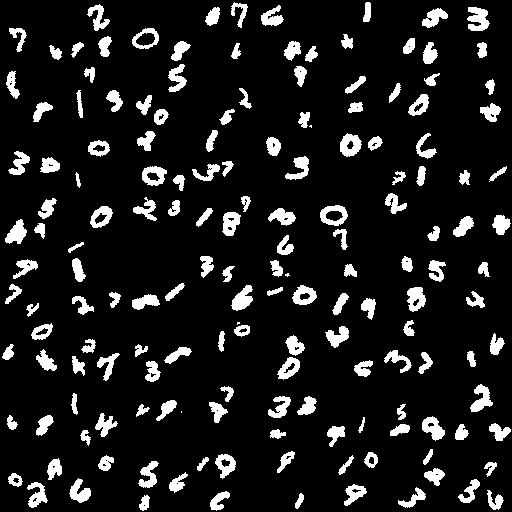

In [283]:
before = gallery(X_test_bow[0:64], ncols = 8)
Image.fromarray(before).convert("L")

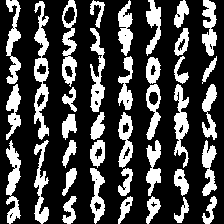

In [285]:
after = gallery(cleaned[0:64], ncols = 8)
Image.fromarray(after).convert("L")

In [24]:
desiredsize = 28

# accumulate a modified dataset
modified = np.ndarray((0, desiredsize, desiredsize), dtype = "uint8")

fails = 0
i = 0
for im in X_test_bow:
    try:
        # find all the contours in that image
        contours = getcontours(im)
        # get all the bounding boxes
        all_rects = [cv2.minAreaRect(cnt) for cnt in contours]
        # compute the area of the each bounding box
        areas = [rectarea(r) for r in all_rects]
        # Pck only the largest bounding box
        largestrect_idx = np.argmax(areas)
        rect = all_rects[largestrect_idx]

        # Extract just that part of the image
        img_croped = crop_minAreaRect(im, rect)

        """
        Now we have extracted the largest contour, using the minimum area rectangle. 
        Presumably, this image will not be square, and it will not be the same size for all digits.

        To get nice, evently sized squares, do:

        1. For each extracted rectangle, scale it so that the largest dimension is 
           the dimension of the final square image. 
        2. Create a black square image of the appropriate size.
        3. Paste the scaled rectangle onto the square image. 
        4. Add this pasted image to the modified dataset. 
        """
        # ratio to scale image dimensions by, to keep aspect ratio, 
        # but have the larger of the two dimensions equal to `desiredsize`
        ratio = desiredsize/float(max(img_croped.shape))
        # scale the image
        newsize = tuple([int(ratio*s) for s in img_croped.shape])
        """
        One few edge cases, after rotating the largest bounding box, I get 
        a rectangle of zero area. 
        
        This happens for 213 out of 10,000 test examples. Since it's rare, for these
        edge cases I'll resort to taking the contour that has the hightest number of 
        pixels in its connected component. 
        """
        if min(newsize) == 0:
            # Find the contour with the largest number of pixels
            largestcontour_idx = np.argmax([cv2.contourArea(cnt) for cnt in contours])
            # extract the largest contour
            cnt = contours[largestcontour_idx]
            # Get that bounding box
            rect = cv2.minAreaRect(cnt)
            # Extract the image
            img_croped = crop_minAreaRect(im, rect)
            # scale the image so that largest dimension is `largestsize`
            ratio = desiredsize/float(max(img_croped.shape))
            newsize = tuple([int(ratio*s) for s in img_croped.shape])
            
        im = Image.fromarray(img_croped).resize(newsize)
        # create a black square of the appropriate dimensions
        black = Image.new("L", size = (desiredsize,desiredsize))
        # put the image onto this black image
        black.paste(im,((desiredsize - newsize[0])//2,
                   (desiredsize - newsize[1])//2))

        # add this image to the modified dataset
        modified = np.append(modified, np.array(black))
    except:
        fails += 1
#         print (i)
    i +=1
    
print (fails)
modified = modified.reshape((10000 - fails,desiredsize,desiredsize))

126
